## 1. Overall

In [1]:
import os, sys, time, warnings
import pandas as pd
import seaborn as sns
import datetime as dt
import lightgbm as lgb
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import heapq

sys.path.append(os.path.abspath(os.path.dirname("../")))
from modules import edaViz

warnings.filterwarnings('ignore')
%matplotlib inline

In [31]:
trainLabels.to_hdf("../dataset/edaViz/trainEdaViz.h5", "trainEdaViz")
testLabels.to_hdf("../dataset/edaViz/testEdaViz.h5", "testEdaViz")
histTrans.to_hdf("../dataset/edaViz/histTrans.h5", 'histTrans')

In [2]:
%%time
histTrans = pd.read_hdf("../dataset/edaViz/histTrans.h5", "histTrans")
trainLabels = pd.read_hdf("../dataset/edaViz/train.h5", "train")
testLabels = pd.read_hdf("../dataset/edaViz/test.h5", "test")

Wall time: 49.4 s


In [5]:
edaViz.printInfo('histTrans',histTrans)
edaViz.printDescribe('histTrans',histTrans)

histTrans information :  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29112361 entries, 0 to 29112360
Data columns (total 14 columns):
authorized_flag         bool
card_id                 object
city_id                 int64
category_1              object
installments            int64
category_3              object
merchant_category_id    int64
merchant_id             object
month_lag               int64
purchase_amount         float64
purchase_date           object
category_2              float64
state_id                int64
subsector_id            int64
dtypes: bool(1), float64(2), int64(6), object(5)
memory usage: 3.1+ GB


histTrans Describe :  
             city_id  installments  merchant_category_id     month_lag  \
count  2.911236e+07  2.911236e+07          2.911236e+07  2.911236e+07   
mean   1.293256e+02  6.484954e-01          4.810130e+02 -4.487294e+00   
std    1.042563e+02  2.795577e+00          2.493757e+02  3.588800e+00   
min   -1.000000e+00 -1.000000e+00        

In [ ]:
histTransCount = Counter(histTrans['card_id'])
trainLabels['transCount'] = trainLabels['card_id'].apply(lambda row: histTransCount[row])
testLabels['transCount'] = testLabels['card_id'].apply(lambda row: histTransCount[row])

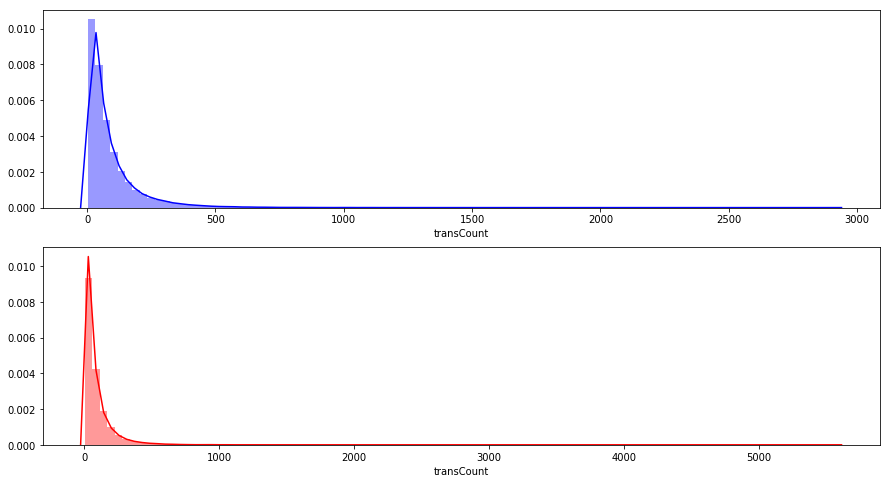

In [54]:
edaViz.compareTrainTest('transCount', bins=100)

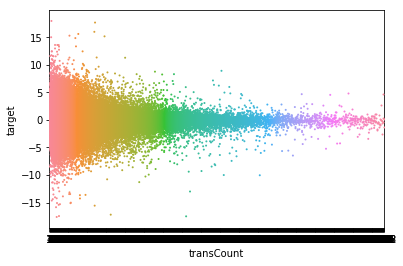

In [3]:
sns.stripplot(x=trainLabels['transCount'], y=trainLabels['target'], size=2)

## 2. authorized flag


### Overview

In [4]:
edaViz.printUniqCount(histTrans[['authorized_flag']])

authorized_flag Unique :  
 [ True False] 

authorized_flag Count :  
 True     26595452
False     2516909
Name: authorized_flag, dtype: int64 




In [ ]:
histTrans['authorized_flag'] = (histTrans['authorized_flag']=='Y')

### Counting Authorized Transaction

In [4]:
%%time
authGroup= histTrans[['card_id', 'authorized_flag']].groupby(['card_id'])
trainLabels['authCount'] = edaViz.mergeGroupby(trainLabels, authGroup['authorized_flag'], np.sum)
testLabels['authCount'] = edaViz.mergeGroupby(testLabels, authGroup['authorized_flag'], np.sum)

Wall time: 10.4 s


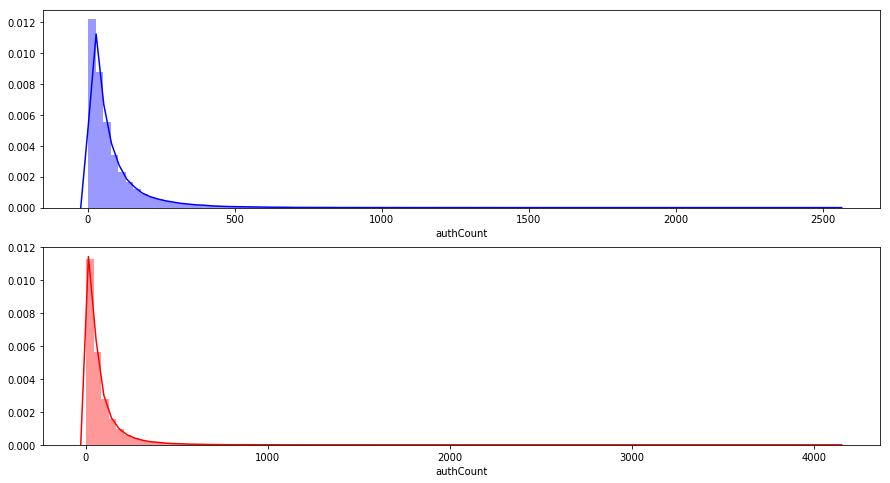

In [55]:
edaViz.compareTrainTest('authCount', bins=100)

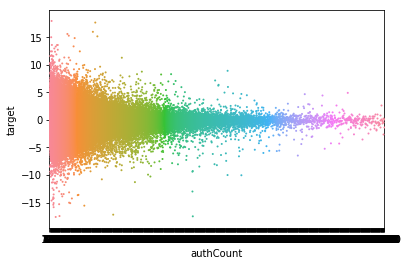

In [5]:
sns.stripplot(x=trainLabels['authCount'], y=trainLabels['target'], size=2)

Wall time: 24.3 s


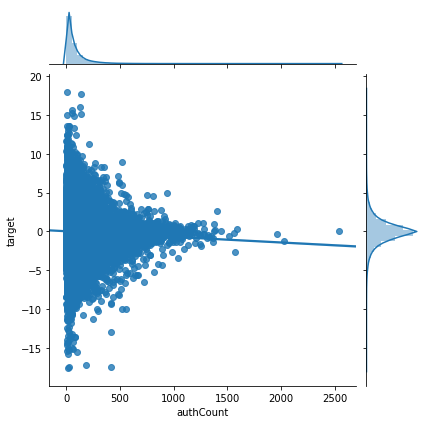

In [10]:
%time sns.jointplot(x=trainLabels['authCount'], y=trainLabels['target'], kind='reg')

### Authorized Transaction Ratio

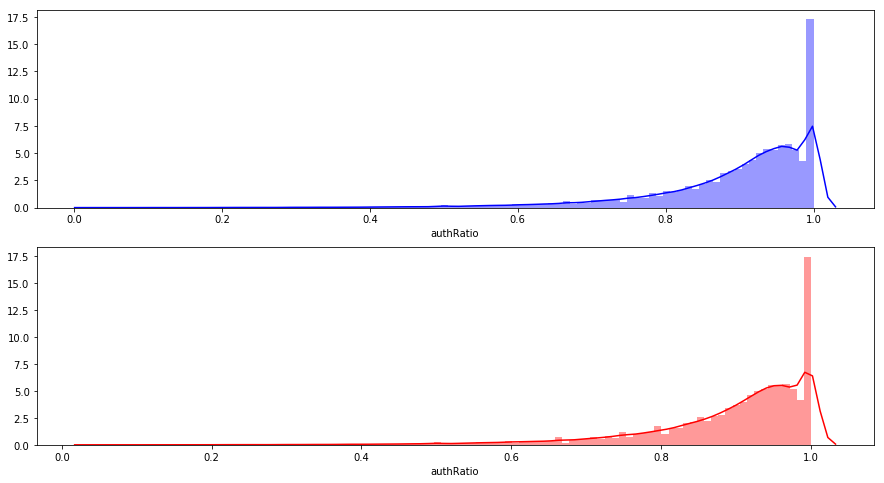

In [56]:
trainLabels['authRatio'] = trainLabels['authCount'] / trainLabels['transCount']
testLabels['authRatio'] = testLabels['authCount'] / testLabels['transCount']

compareTrainTest('authRatio', bins=100)

In [7]:
print('1 : ', trainLabels['card_id'][trainLabels['authRatio']==1].count())
for i in range(10):
    lower = i/10
    higher = (i+1)/10
    print('over {} ~ under {} : {}'.format(lower, higher,
        trainLabels['card_id'][trainLabels['authRatio']>=lower][trainLabels['authRatio']<higher].count()))

1 :  30755
over 0.0 ~ under 0.1 : 12
over 0.1 ~ under 0.2 : 73
over 0.2 ~ under 0.3 : 283
over 0.3 ~ under 0.4 : 593
over 0.4 ~ under 0.5 : 1335
over 0.5 ~ under 0.6 : 3442
over 0.6 ~ under 0.7 : 7544
over 0.7 ~ under 0.8 : 16987
over 0.8 ~ under 0.9 : 45688
over 0.9 ~ under 1.0 : 92998


Wall time: 25.1 s


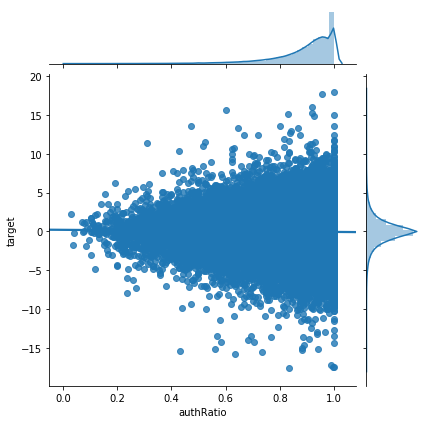

In [9]:
%time sns.jointplot(x=trainLabels['authRatio'], y=trainLabels['target'], kind='reg')

In [46]:
edaViz.briefLgb(['transCount','authCount','authRatio'])

{'rmse-mean': [1.718006152061217,
  1.7179806981671628,
  1.717951183799062,
  1.7179171197457463,
  1.717881157549042],
 'rmse-stdv': [0.010526363542579062,
  0.010524664469505934,
  0.010525239168952536,
  0.01052486734386209,
  0.010523236864912444]}

## 3. city id

In [45]:
len(histTrans['city_id'].unique())

308

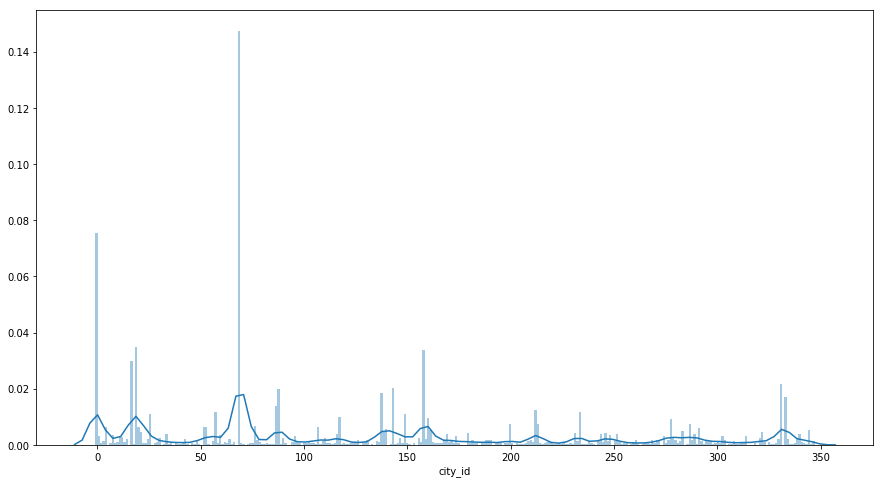

In [60]:
fig, ax = plt.subplots(1,1,figsize=(15,8))
sns.distplot(histTrans['city_id'], bins=308, ax=ax)

In [27]:
%%time
cityIdGroup = histTrans[['card_id','city_id']].groupby(['card_id'])
trainLabels['cityIdMode'] = edaViz.mergeGroupby(trainLabels, cityIdGroup['city_id'], edaViz.mode)
testLabels['cityIdMode'] = edaViz.mergeGroupby(testLabels, cityIdGroup['city_id'], edaViz.mode)

Wall time: 19.4 s


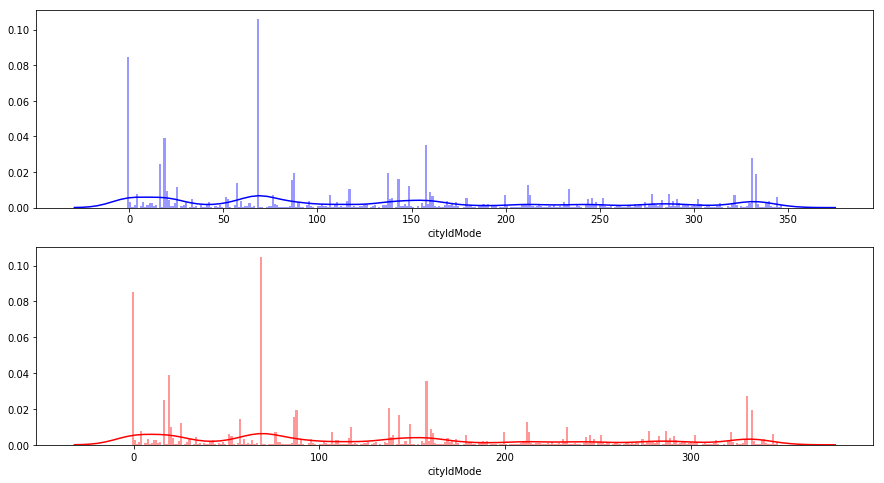

In [52]:
edaViz.compareTrainTest('cityIdMode', bins=308)

Wall time: 3min 1s


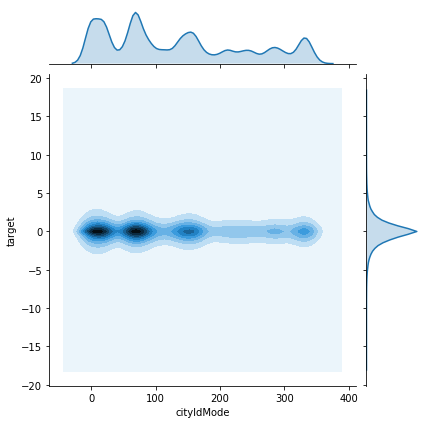

In [62]:
%time sns.jointplot(x=trainLabels['cityIdMode'], y=trainLabels['target'], kind='kde')

In [61]:
edaViz.briefLgb(['cityIdMode'])

{'rmse-mean': [1.718024940731373,
  1.7180223045874825,
  1.7180196187974204,
  1.7180170333969216,
  1.7180147389018436],
 'rmse-stdv': [0.010524628203679746,
  0.010524637123000266,
  0.01052453121403958,
  0.010524241338504062,
  0.010523958377458347]}

## 4. 